In [1]:
!pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite


In [2]:
import keras

In [3]:
import tensorflow as tf

In [4]:
import pandas as pd

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
if tf.test.is_gpu_available():
    BATCH_SIZE=512
    EPOCHS=5
    MAX_LEN=75
    EMBEDDING=40
else:
    BATCH_SIZE=32
    EPOCHS=5
    MAX_LEN=75
    EMBEDDING=20


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [8]:
data=pd.read_csv(r'C:\Users\My Pc\ML_project\ner_dataset.csv', encoding='latin1')

In [9]:
data=data.fillna(method='ffill')

In [10]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [11]:
print('no f sentences', len(data.groupby(['Sentence #'])))
words=list(set(data['Word'].values))
n_words=len(words)
print("no of words:",n_words)

tags=list(set(data['Tag'].values))
print(tags)
n_tags=len(tags)
print('no of tags', n_tags)
data.head(10)

no f sentences 47959
no of words: 35178
['I-geo', 'I-tim', 'I-nat', 'B-geo', 'B-gpe', 'B-tim', 'I-eve', 'I-gpe', 'I-per', 'B-art', 'B-nat', 'B-eve', 'B-org', 'I-org', 'I-art', 'B-per', 'O']
no of tags 17


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [12]:
class SentenceGetter(object):
    """"class to get the sentence in this format: [(Token_n, Part_of_speech_1,Tag_1)]"""
    
    def __init__(self,data):
        self.n_sent=1
        self.data=data
        self.empty=False
        agg_func=lambda s:[(w,p,t) for w, p,t in zip(s['Word'].values.tolist(),
                                                     s['POS'].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped =self.data.groupby('Sentence #').apply(agg_func)
        self.sentences=[ s for s in self.grouped]
    def get_next(self):
        try:
            s = self.grouped['Sentence:{}'.format(self.n_sent)]
            self.n_sent+= 1
            return s
        except:
            return None
getter=SentenceGetter(data)
sent=getter.get_next()
print('THis is what sentence look like:' , sent)

THis is what sentence look like: None


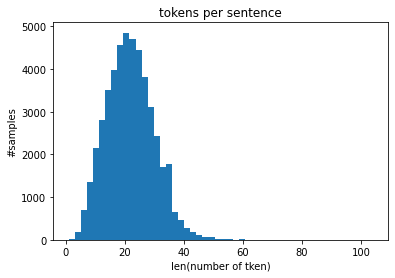

In [15]:
sentences=getter.sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.title('tokens per sentence')
plt.xlabel('len(number of tken)')
plt.ylabel('#samples')
plt.show()


In [16]:
# Data Preprocessing
#Before feeding the data into the model, we have to preprocess the text.



In [18]:
word2idx={w: i + 2 for i, w in enumerate(words)}
word2idx['UNK']=1 #UNK = unknown words
word2idx['PAD']=0 # padding
idx2word={i:w for w, i in word2idx.items()}
#vocabulary key:label/Tag-> value:tag_index
tag2idx={t:i+1 for i,t in enumerate(tags)}
tag2idx['PAD']=0
idx2tag={i:w for w, i in tag2idx.items()}
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 11091
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 4
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [20057 14418 34374 25431   159 18637 18409  7472  9953 14779 31570 35005
  5362 24187 17085 14779 24594 14418  5738 30202 10127 26948 30965 25123
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0.